# **Exploring Maximum Likelihood Estimation in Portfolio Risk Modeling**

This project is a means to explore statistical estimation methods in portfolio risk modeling, with a focus on Maximum Likelihood Estimation (MLE).

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# A Pretty Balanced Portfolio
tickers = ["AAPL", "GOOG", "META", # Market Exposure
           "TLT", "IEF", "LQD", # Bonds
           "GLD", "USO", "DBC" # Commodities
          ]

## **Maximum Likelihood Estimation**

In classical portfolio theory, risk is encoded in the covariance matrix of asset returns. Accurate estimation of this matrix is central to understanding diversification, portfolio variance, and the contribution of individual assets to overall risk.

To set up our statistical framework: stock returns are the outcome of many small, random shocks. By the Central Limit Theorem, the accumulation of these shocks tends toward a normal distribution. Thus, normality provides a natural first approximation for modeling returns. We therefore make our first two assumptions: Returns are normal and independent with respect to time.


$$
X_1, X_2, \ldots, X_{p} \;\sim\; \text{i.i.d. } \mathcal{N}_p(\mu, \Sigma)
$$

where each $X_t$ is a $p$-dimensional vector of returns (in our case, $p = 10$ assets).

Maximum Likelihood Estimation is a very useful technique that asks, given our assumed distribution, what parameter values would make this data most likely to occur? For our multivariate normal distribution, we derive our estimator as follows, beginning with our density function:

$$
f_X(x \mid \mu, \Sigma)
= \frac{1}{(2\pi)^{p/2} |\Sigma|^{1/2}}
\exp\!\left( -\tfrac{1}{2}(x-\mu)^\top \Sigma^{-1} (x-\mu) \right)
$$

For independent observations $X_1, X_2, \ldots, X_n$, the likelihood is the product

$$
L(\mu, \Sigma)
= \prod_{t=1}^n f_X(X_t \mid \mu, \Sigma)
$$

Taking logs, the log-likelihood is  

$$
\ell(\mu, \Sigma)
= -\frac{n}{2} \log | \Sigma |
- \frac{1}{2} \sum_{t=1}^n (X_t - \mu)^\top \Sigma^{-1} (X_t - \mu)
- \frac{np}{2} \log(2\pi)
$$

Taking the derivative with respect to $\mu$:

$$
\frac{\partial \ell}{\partial \mu}
= \sum_{t=1}^n \Sigma^{-1}(X_t - \mu)
$$

Setting equal to zero:  

$$
\sum_{t=1}^n (X_t - \mu) = 0
\quad \Longrightarrow \quad
\hat{\mu} = \frac{1}{n} \sum_{t=1}^n X_t
$$


Taking the derivative with respect to $\Sigma$:

$$
\frac{\partial}{\partial \Sigma} \, \ell(\mu, \Sigma)
= -\frac{n}{2}\Sigma^{-1}
+ \frac{1}{2}\Sigma^{-1}\!\left(\sum_{t=1}^n (X_t - \mu)(X_t - \mu)^\top\right)\!\Sigma^{-1}
$$

Setting equal to zero and rearranging:  

$$
\hat{\Sigma} = \frac{1}{n} \sum_{t=1}^n (X_t - \hat{\mu})(X_t - \hat{\mu})^\top
$$

Our resultant Maximum Likelihood Estimators $\hat{\mu}$ and $\hat{\Sigma}$ are estimates of the mean and covariances which we will get directly from our return data.


/var/folders/7y/526143213zldpshyyqyt65vw0000gn/T/ipykernel_74215/334805328.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed


Estimated Mean Vector:
Ticker
AAPL    0.000806
DBC     0.000024
GLD     0.001081
GOOG    0.001202
IEF     0.000127
LQD     0.000265
META    0.002199
TLT    -0.000045
USO     0.000075
Name: Mean Return, dtype: float64

Estimated Covariance Matrix:
Ticker      AAPL       DBC       GLD      GOOG       IEF       LQD      META  \
Ticker                                                                         
AAPL    0.000299  0.000031  0.000012  0.000178  0.000007  0.000028  0.000205   
DBC     0.000031  0.000097  0.000032  0.000031 -0.000004  0.000002  0.000024   
GLD     0.000012  0.000032  0.000094  0.000018  0.000017  0.000017  0.000009   
GOOG    0.000178  0.000031  0.000018  0.000388  0.000004  0.000023  0.000271   
IEF     0.000007 -0.000004  0.000017  0.000004  0.000024  0.000024 -0.000001   
LQD     0.000028  0.000002  0.000017  0.000023  0.000024  0.000029  0.000024   
META    0.000205  0.000024  0.000009  0.000271 -0.000001  0.000024  0.000703   
TLT     0.000020 -0.000007  0.000

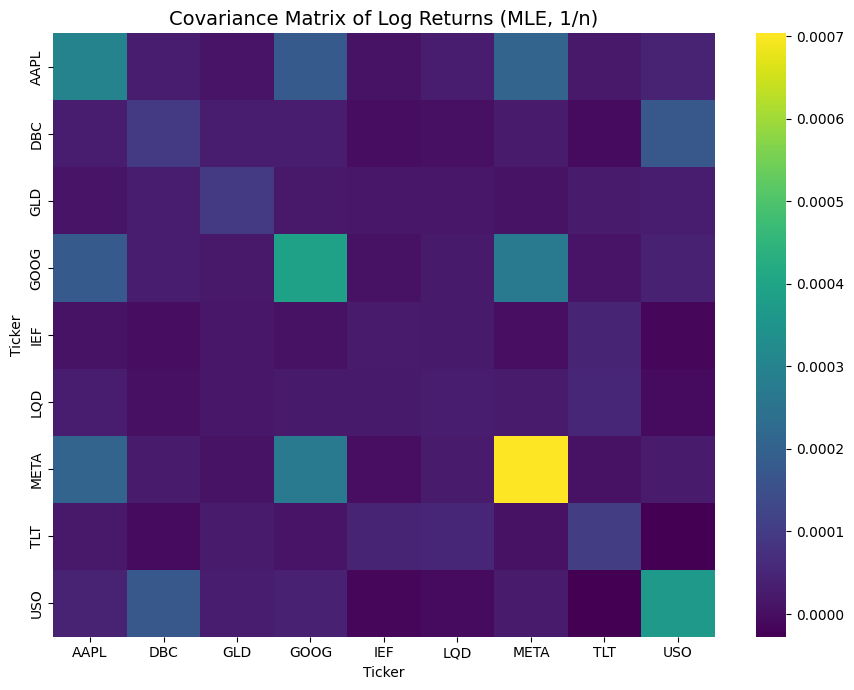

In [3]:
end = datetime.today()
start = end - pd.DateOffset(years=3)

prices = yf.download(tickers, start=start, end=end)['Close']
log_returns = np.log(prices / prices.shift(1)).dropna()

# MLE of mean vector (sample mean)
mu_hat = log_returns.mean().values

# MLE of covariance matrix (sample covariance)
n = log_returns.shape[0]
sig_hat = (log_returns - log_returns.mean()).T.dot(log_returns - log_returns.mean()) / n

mu_hat_series = pd.Series(mu_hat, index=log_returns.columns, name="Mean Return")
sig_hat_df = pd.DataFrame(sig_hat, index=log_returns.columns, columns=log_returns.columns)

print("Estimated Mean Vector:")
print(mu_hat_series)

print("\nEstimated Covariance Matrix:")
print(sig_hat_df)

plt.figure(figsize=(9,7))
sns.heatmap(sig_hat_df, annot=False, cmap="viridis", fmt=".2e")
plt.title("Covariance Matrix of Log Returns (MLE, 1/n)", fontsize=14)
plt.tight_layout()
plt.show()


We can interpret our Covariance Matrix as a quantitative description of how asset returns move relative to one another: The diagonal entries represent the variances of each asset’s returns, and the off-diagonal elements capture the co-movement of asset pairs.

Our resultant covariance matrix confirmed a common trend that sector-specific assets tend to move together, especially when you look at tech stocks. Covariances between bonds and equities were generally small in magnitude, occasionally slightly positive or negative. This suggests that bonds remain relatively independent from equity movements, offering diversification benefits in portfolio construction. Commodities were a mixed bag, but Gold (GLD) showed weaker correlations with both equities and bonds, underscoring its role as a more independent hedge.


## **Goodness of our Estimators**

We must understand that our  $\hat{\mu}$ and $\hat{\Sigma}$ are estimates. As estimates, the natural question is how good of an estimate are they? As a matter of fact, how efficient can any estimator of these parameters be?

A first step would be to calculate bias. A biased estimator would mean if we averaged our estimator over many samples, it would not reflect the true population parameter. For $\hat\mu$:

$$
\mathbb E[\hat\mu]
= \frac{1}{n}\sum_{t=1}^n \mathbb E[X_t]
= \frac{1}{n}\sum_{t=1}^n \mu
= \mu.
$$

Hence $\hat\mu$ is exactly unbiased. For $\hat\Sigma$:

$$
\hat\Sigma \;=\; \frac{1}{n}\sum_{t=1}^n (X_t-\hat\mu)(X_t-\hat\mu)^\top.
$$

Let $Y_t = X_t - \mu$ and $\bar Y = \hat\mu - \mu = \frac{1}{n}\sum_{t=1}^n Y_t$. Note that $\mathbb E[Y_t]=0$, $\mathrm{Cov}(Y_t)=\Sigma$, and $\mathrm{Cov}(\bar Y)=\Sigma/n$.
Using $\sum_{t=1}^n (Y_t-\bar Y)(Y_t-\bar Y)^\top = \sum_{t=1}^n Y_t Y_t^\top - n\,\bar Y \bar Y^\top$, we have

$$
\hat\Sigma
= \frac{1}{n}\sum_{t=1}^n (Y_t-\bar Y)(Y_t-\bar Y)^\top
= \frac{1}{n}\left(\sum_{t=1}^n Y_t Y_t^\top - n\,\bar Y \bar Y^\top\right).
$$

Taking expectations,

$$
\mathbb E\!\left[\sum_{t=1}^n Y_t Y_t^\top\right] \;=\; n\,\Sigma,
\qquad
\mathbb E\!\left[n\,\bar Y \bar Y^\top\right]
= n\,\mathbb E[\bar Y\bar Y^\top]
= n\,\mathrm{Cov}(\bar Y)
= n\,\frac{\Sigma}{n}
= \Sigma.
$$

Therefore,

$$
\mathbb E[\hat\Sigma]
= \frac{1}{n}\big(n\Sigma - \Sigma\big)
= \frac{n-1}{n}\,\Sigma.
$$

So our covariance matrix parameter is not exactly unbiased. However we note that As n tends to infinity, the front term converges to one, giving us asymptotic unbiasedness, meaning we are unbiased with large samples of data.

The Fisher Information measures the sensitivity of the likelihood function to changes in the underlying parameter: if small shifts in the parameter produce large changes in the likelihood, the data are said to be highly informative. In practical terms, a greater Fisher Information means we can estimate the parameter more precisely. We begin the derivation with our log-likelihood function, same assumptions:

$$
\ell(\mu, \Sigma)
= -\frac{n}{2} \log | \Sigma |
- \frac{1}{2} \sum_{t=1}^n (X_t - \mu)^\top \Sigma^{-1} (X_t - \mu)
- \frac{np}{2} \log(2\pi)
$$

For parameter $\theta$ with log-likelihood $\ell(\theta)$, the Fisher Information is

$$
\mathcal{I}(\theta)
= -\,\mathbb{E}\!\left[\frac{\partial^2 \ell(\theta)}{\partial \theta\,\partial \theta^\top}\right]
= \operatorname{Var}\!\left(\frac{\partial \ell(\theta)}{\partial \theta}\right),
$$

under standard regularity conditions.

Dropping constants that do not depend on the parameter of interest,

$$
\ell(\mu, \Sigma)
= -\frac{n}{2} \log | \Sigma |
- \frac{1}{2} \sum_{t=1}^n (X_t - \mu)^\top \Sigma^{-1} (X_t - \mu)
\;+\; \text{const},
$$

We compute the score and Hessian, then take expectations to obtain $\mathcal{I}$.

Score w.r.t. $\mu$:
$$
\frac{\partial \ell}{\partial \mu}
= \sum_{t=1}^n \Sigma^{-1}(X_t - \mu).
$$

Hessian w.r.t. $\mu$:
$$
\frac{\partial^2 \ell}{\partial \mu\,\partial \mu^\top}
= -\,n\,\Sigma^{-1}.
$$

Fisher Information:
$$
\boxed{\;\mathcal{I}_\mu \;=\; -\,\mathbb{E}\!\left[\frac{\partial^2 \ell}{\partial \mu\,\partial \mu^\top}\right] \;=\; n\,\Sigma^{-1}\;}
$$

In the multivariate case, derivatives w.r.t. $\Sigma$ get complex, so we will just quote a textbook. Thus the (vectorized) score and expected Hessian yield the Fisher Information
for $\mathrm{vec}(\Sigma)$:

$$
\boxed{\;\mathcal{I}_{\Sigma} \;=\; \frac{n}{2}\,\big(\Sigma^{-1}\otimes \Sigma^{-1}\big)\;}
$$
where $\otimes$ denotes the Kronecker product.

These results highlight an important distinction. For the mean vector, the Fisher Information leads to a clean and interpretable Cramér-Rao Lower Bound (CRLB). The CRLB states that for any unbiased estimator $\hat\theta$ of a parameter $\theta$, its covariance matrix is bounded below by the inverse of the Fisher Information:

$$
\operatorname{Cov}(\hat\theta) \;\succeq\; \mathcal{I}(\theta)^{-1}.
$$

Applying this to the mean, we obtain

$$
\operatorname{Cov}(\hat\mu) \;\succeq\; \frac{\Sigma}{n}.
$$

To verify this result empirically, we can turn to resampling methods such as data bootstraping. By repeatedly resampling our return data and recalculating the sample mean, we can approximate the sampling distribution of $\hat\mu$ and compute its empirical covariance. Comparing this bootstrap covariance to the theoretical CRLB, $\Sigma/n$, provides a direct numerical check that our derivations hold in practice.

Empirical Cov(mu_hat)  (bootstrap):


Ticker,AAPL,DBC,GLD,GOOG,IEF,LQD,META,TLT,USO
Ticker,,,,,,,,,
AAPL,4.000000e-07,4.000000e-08,2.000000e-08,2.400000e-07,1.000000e-08,4.000000e-08,2.700000e-07,2.000000e-08,6.000000e-08
DBC,4.000000e-08,1.300000e-07,5.000000e-08,4.000000e-08,-0.000000e+00,0.000000e+00,2.000000e-08,-1.000000e-08,2.300000e-07
GLD,2.000000e-08,5.000000e-08,1.200000e-07,3.000000e-08,2.000000e-08,2.000000e-08,1.000000e-08,3.000000e-08,5.000000e-08
GOOG,2.400000e-07,4.000000e-08,3.000000e-08,5.100000e-07,1.000000e-08,3.000000e-08,3.500000e-07,1.000000e-08,5.000000e-08
IEF,1.000000e-08,-0.000000e+00,2.000000e-08,1.000000e-08,3.000000e-08,3.000000e-08,0.000000e+00,6.000000e-08,-2.000000e-08
LQD,4.000000e-08,0.000000e+00,2.000000e-08,3.000000e-08,3.000000e-08,4.000000e-08,3.000000e-08,6.000000e-08,-1.000000e-08
META,2.700000e-07,2.000000e-08,1.000000e-08,3.500000e-07,0.000000e+00,3.000000e-08,9.400000e-07,1.000000e-08,3.000000e-08
TLT,2.000000e-08,-1.000000e-08,3.000000e-08,1.000000e-08,6.000000e-08,6.000000e-08,1.000000e-08,1.300000e-07,-3.000000e-08
USO,6.000000e-08,2.300000e-07,5.000000e-08,5.000000e-08,-2.000000e-08,-1.000000e-08,3.000000e-08,-3.000000e-08,4.900000e-07



Theoretical CRLB (Sigma_hat / n):


Ticker,AAPL,DBC,GLD,GOOG,IEF,LQD,META,TLT,USO
Ticker,,,,,,,,,
AAPL,4.000000e-07,4.000000e-08,2.000000e-08,2.400000e-07,1.000000e-08,4.000000e-08,2.700000e-07,3.000000e-08,6.000000e-08
DBC,4.000000e-08,1.300000e-07,4.000000e-08,4.000000e-08,-1.000000e-08,0.000000e+00,3.000000e-08,-1.000000e-08,2.300000e-07
GLD,2.000000e-08,4.000000e-08,1.200000e-07,2.000000e-08,2.000000e-08,2.000000e-08,1.000000e-08,3.000000e-08,4.000000e-08
GOOG,2.400000e-07,4.000000e-08,2.000000e-08,5.200000e-07,1.000000e-08,3.000000e-08,3.600000e-07,1.000000e-08,5.000000e-08
IEF,1.000000e-08,-1.000000e-08,2.000000e-08,1.000000e-08,3.000000e-08,3.000000e-08,-0.000000e+00,6.000000e-08,-2.000000e-08
LQD,4.000000e-08,0.000000e+00,2.000000e-08,3.000000e-08,3.000000e-08,4.000000e-08,3.000000e-08,7.000000e-08,-1.000000e-08
META,2.700000e-07,3.000000e-08,1.000000e-08,3.600000e-07,-0.000000e+00,3.000000e-08,9.300000e-07,1.000000e-08,3.000000e-08
TLT,3.000000e-08,-1.000000e-08,3.000000e-08,1.000000e-08,6.000000e-08,7.000000e-08,1.000000e-08,1.400000e-07,-4.000000e-08
USO,6.000000e-08,2.300000e-07,4.000000e-08,5.000000e-08,-2.000000e-08,-1.000000e-08,3.000000e-08,-4.000000e-08,4.800000e-07


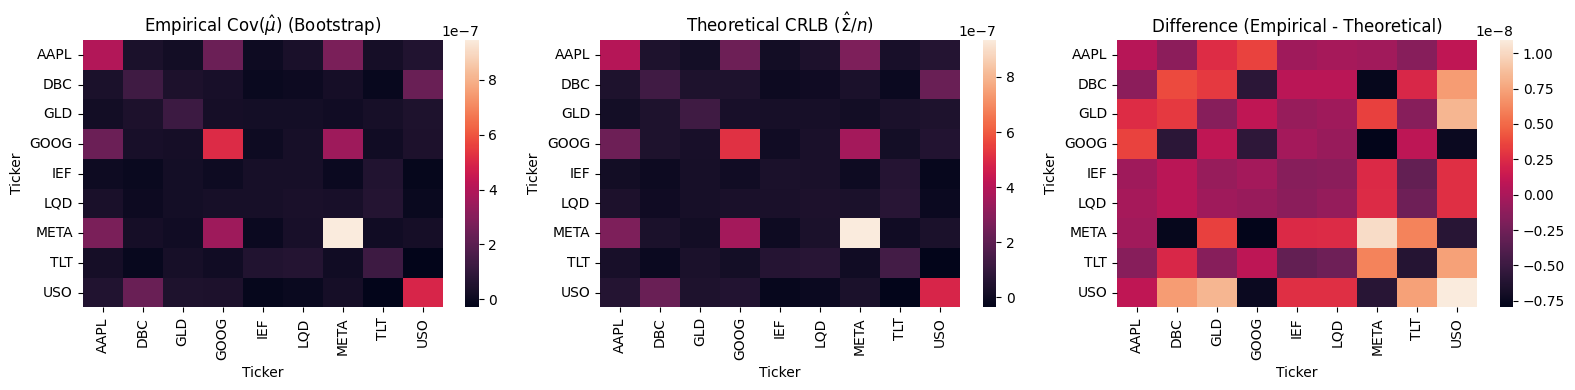

In [4]:
R = 5000
rng = np.random.default_rng(42)

p = log_returns.shape[1]
cols = log_returns.columns

mu_boot = np.zeros((R, p))

X = log_returns.values

for r in range(R):
    idx = rng.integers(low=0, high=n, size=n, endpoint=False)
    Xb = X[idx, :]
    mu_boot[r, :] = Xb.mean(axis=0)

emp_cov = np.cov(mu_boot.T, bias=True)

th_cov = (sig_hat_df.values) / n

emp_cov_df = pd.DataFrame(emp_cov, index=cols, columns=cols)
th_cov_df  = pd.DataFrame(th_cov,  index=cols, columns=cols)

print("Empirical Cov(mu_hat)  (bootstrap):")
display(emp_cov_df.round(8))
print("\nTheoretical CRLB (Sigma_hat / n):")
display(th_cov_df.round(8))

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

sns.heatmap(emp_cov_df, annot=False, fmt=".2e", ax=ax[0])
ax[0].set_title("Empirical Cov($\\hat{\\mu}$) (Bootstrap)")

sns.heatmap(th_cov_df, annot=False, fmt=".2e", ax=ax[1])
ax[1].set_title("Theoretical CRLB ($\\hat{\\Sigma}/n$)")

diff_df = emp_cov_df - th_cov_df
sns.heatmap(diff_df, annot=False, fmt=".2e", ax=ax[2])
ax[2].set_title("Difference (Empirical - Theoretical)")

plt.tight_layout()
plt.show()

This tells us that sample means of returns can, in principle, be estimated with variance that decreases at the familiar $1/n$ rate, becoming more precise as more observations accumulate. However, in financial applications expected returns are typically very small relative to their volatility, so even though the theoretical bound looks favorable, estimates of $\mu$ remain noisy in finite samples and are often unreliable for portfolio construction.

Estimating the covariance matrix is even more demanding. Although its entries also converge at a $1/n$ rate, the number of distinct parameters grows quadratically with the number of assets, magnifying estimation error. As a result, $\hat{\Sigma}$ is much less stable in practice, especially when the sample size $n$ is not large relative to the dimension $p$. This fragility motivates the use of more robust approaches for risk modeling, such as shrinkage estimators, heavy-tailed alternatives like the multivariate Student-$t$, or Bayesian methods that introduce informative priors to stabilize estimation.